# Linked Structures

## Agenda

1. Motivation
2. Wishlist
3. Mechanisms
4. Linked Data Structures

## 1. Motivation: built-in, array-backed list runtimes

What are the runtime complexities of some common operations for updating an array-backed list?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit
%matplotlib inline

### Index-based update

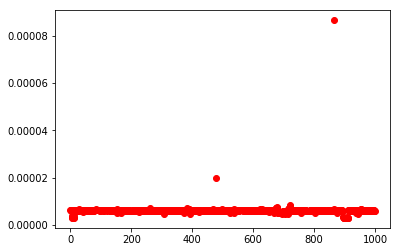

In [2]:
size = 10_000

ts = [timeit('lst[{}] = None'.format(n),
             setup='lst = list(range({}))'.format(size),
             number=100)
      for n in range(0, size, 10)]

plt.plot(ts, 'ro');

### Appending

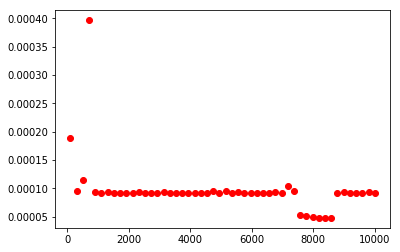

In [3]:
ns = np.linspace(100, 10000, 50, dtype=int)

ts = [timeit('lst.append(None)',
             setup='lst = list(range({}))'.format(n),
             number=1000)
      for n in ns]

plt.plot(ns, ts, 'ro');

the append operation should be constant time because the size of the list doesnt matter, it takes a constant amount of time to add something to a list

### Insertion & Deletion

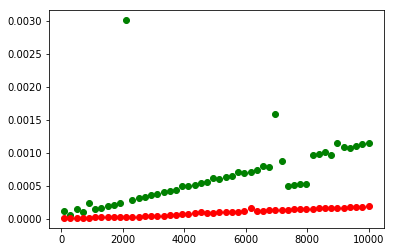

In [4]:
ns = np.linspace(100, 10000, 50, dtype=int)

# timing insertion at front
ins_ts = [timeit('lst.insert(0, None)',
                 setup='lst = list(range({}))'.format(n),
                 number=100)
          for n in ns]

# timing deletion at front
del_ts = [timeit('del lst[0]',
                 setup='lst = list(range({}))'.format(n),
                 number=100)
          for n in ns]

plt.plot(ns, ins_ts, 'go')
plt.plot(ns, del_ts, 'ro');

green - insertion
+ for larger lists, the time it takes increases at a linear rate, but my laptop increases at a bigger linear rate

red - deletion
+ for larger lists, the time it takes increases at a linear rate, a smaller linear rate than insertion

both have linear runtime complexities

### Concatenation
+ taking 2 lists and adding them together

In [5]:
def concat1(lst1, lst2):
    for x in lst2:
        lst1.append(x)
    return lst1

def concat2(lst1, lst2):
    lst1.extend(lst2)
    return lst1

def concat3(lst1, lst2):
    return lst1 + lst2

+ concat1 - red - append 
 - append is a constant 
+ concat2 - green - extend
 - extend has the same runtime complexity as plus 
 - extend is linear bc its basically append looped 
 - however extend is faster than append bc the ftn is probably optimized, implemented in c code (lower level language), faster than doing it element to element like in python code
+ concat3 - blue - plus
 - plus is also linear
 - slightly slower than extend in terms of runtime complexities

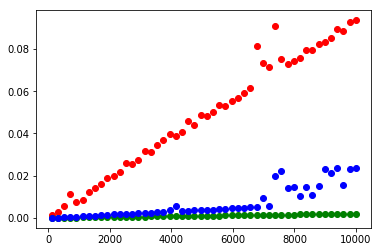

In [6]:
ns = np.linspace(100, 10000, 50, dtype=int)

ts = [[timeit('{}(lst1, lst2)'.format(fn),
              setup='lst1 = list(range({})); lst2 = list(range({}))'.format(n, n),
              number=100,
              globals=globals())
       for n in ns] for fn in ('concat1', 'concat2', 'concat3')]

plt.plot(ns, ts[0], 'ro')
plt.plot(ns, ts[1], 'go')
plt.plot(ns, ts[2], 'bo');

### Conclusion

While index-based updates and appends are $O(1)$, operations that may require changing the relative positions of elements en masse (e.g., insertion, deletion, concatenation) are $O(N)$. 

This is due to the **monolithic, contiguous memory allocation** of the array used to hold references to elements in the list.

## 2. Wishlist

For applications that frequently perform operations such as insertions & deletions (which are inefficient in an array-backed list) we would like to have an improved storage mechanism that:

- does **not** require monolithic, contiguous memory allocation,
- supports flexible and efficient reorganization of substructures (e.g., for concatenation and relocation),
- and allows us to build other commonly needed operations (e.g., for indexing, iteration, search) on top of it.

## 3. Mechanisms

### 3.1. Two-Element Lists

In [7]:
# data items
i1 = 'lions'
i2 = 'tigers'
i3 = 'bears'
i4 = 'oh, my'

In [10]:
lst = [i1, i2, i3, i4] #how to usually put all items in a list

In [15]:
# creating individual "links"
l1 = [i1, None]
l2 = [i2, None]
l3 = [i3, None]
l4 = [i4, None]

In [16]:
# link-ing them together
l1[1] = l2 #stores a ref in l1's second index to l2
l2[1] = l3
l3[1] = l4

In [18]:
# data access
head = l1
#variable called head, contains ref to the first link l1

In [19]:
head[0]

'lions'

In [20]:
#to access the second link, look at second index of head
head[1][0]

'tigers'

In [21]:
head[1][1][1][0]

'oh, my'

to traverse the entire list, u need to go to the second index of first list to access the second list

In [25]:
# iteration
def link_iterator(l):
    while l is not None: #when ur one away from the very end
        yield l[0]
        l = l[1] #make the second list as the new head

we use yield so the ftn can now act as an iterator, bc now its very flexible, and can be printed using a for loop (+other stuff)

In [26]:
for x in link_iterator(head):
    print(x)

lions
tigers
bears
oh, my


In [28]:
# prepending - adding a value to the beginning of the list
i0 = 'walruses'
#create a new two slot list, where the 2nd index contains ref to l1
#also need to change new head ref to the new two slot list
l0 = [i0, l1]
head = l0

In [29]:
for x in link_iterator(head):
    print(x)

walruses
lions
tigers
bears
oh, my


In [30]:
# insertion
i2_5 = 'elephants'
#want to insert between tiger and bears
#create a new two slot list, and change ref from l2 to point to new lsit,
#and make this new list point to l3
l2_5 = [i2_5, l3]
l2[1] = l2_5

In [31]:
for x in link_iterator(head):
    print(x)

walruses
lions
tigers
elephants
bears
oh, my


In [32]:
# deletion
# lets say we wann delete elephants, we just have to revert to og conditions
l2[1] = l3

In [33]:
for x in link_iterator(head):
    print(x)

walruses
lions
tigers
bears
oh, my


+ this linking structure makes insertion/deletion to be O(1) instead of O(n)

### 3.2. "Link" objects

In [37]:
class Link:
    def __init__(self, val, next=None):
        self.val = val
        self.next = next

In [38]:
# manually constructing a list
l1 = Link(i1)
l2 = Link(i2)
l3 = Link(i3)
l4 = Link(i4)

In [41]:
l1.next = l2
l2.next = l3
l3.next = l4

In [42]:
# data access
head = l1

In [43]:
head.val

'lions'

In [46]:
head.next.val

'tigers'

In [47]:
head.next.next.next.val
#same as head[1][1][1][0], but not using object attributes

'oh, my'

In [48]:
# iteration
def link_iterator(l):
    while l is not None: 
        yield l.val #yield the value of that link, so .val
        l = l.next #when we're moving from one link to the next, so .next 

In [49]:
for x in link_iterator(head):
    print(x)

lions
tigers
bears
oh, my


## 4. Linked Data Structures

### 4.1 Linked List

In [50]:
class LinkedList:
    class Link:
        def __init__(self, val, next=None):
            self.val = val
            self.next = next

    def __init__(self):
        self.head = None
        
    def prepend(self, val):
        self.head = Link(val, next=self.head) 
    #creating new link with val entered and 
    # its second index refs to the current head
        
    def __iter__(self):
        l = self.head
        while l is not None: 
            yield l.val 
            l = l.next
            
    def __repr__(self):
        return '[' + ','.join(str(x) for x in self) + ']'
        #self can be in a for loop now bc it's iterable from the above method

In [52]:
l = LinkedList()
for x in range(10):
    l.prepend(x) #prepend is a constant, O(1), ftn
l

[9,8,7,6,5,4,3,2,1,0]

### 4.2 Binary Tree

In [ ]:
class BinaryLink:
    def __init__(self, val, left=None, right=None):
        self.val = val
        self.left = left
        self.right = right

In [ ]:
# manual construction of a "tree" representing the expression ((5+3)*(8-4))
t = BinaryLink('*')
t.left = BinaryLink('+')
t.left.left  = BinaryLink('5')
t.left.right = BinaryLink('3')
t.right = BinaryLink('-')
t.right.left  = BinaryLink('8')
t.right.right = BinaryLink('4')

In [ ]:
def print_expr_tree(t):
    if t:
        if not t.val.isdigit():
            print('(', end='')
        print_expr_tree(t.left)
        print(t.val, end='')
        print_expr_tree(t.right)
        if not t.val.isdigit():
            print(')', end='')

In [ ]:
print_expr_tree(t)

### 4.3 N-ary Tree

In [ ]:
class NaryLink:
    def __init__(self, val, n=2):
        self.val = val
        self.children = [None] * n
        
    def __getitem__(self, idx):
        return self.children[idx]
    
    def __setitem__(self, idx, val):
        self.children[idx] = val
        
    def __iter__(self):
        for c in self.children:
            yield c

In [ ]:
root = NaryLink('Kingdoms', n=5)

root[0] = NaryLink('Animalia', n=35)
root[1] = NaryLink('Plantae', n=12)
root[2] = NaryLink('Fungi', n=7)
root[3] = NaryLink('Protista', n=5)
root[4] = NaryLink('Monera', n=5)

root[2][0] = NaryLink('Chytridiomycota')
root[2][1] = NaryLink('Blastocladiomycota')
root[2][2] = NaryLink('Glomeromycota')
root[2][3] = NaryLink('Ascomycota')
root[2][4] = NaryLink('Basidiomycota')
root[2][5] = NaryLink('Microsporidia')
root[2][6] = NaryLink('Neocallimastigomycota')

def tree_iter(root):
    if root:
        yield root.val
        for c in root:
            yield from tree_iter(c)

In [ ]:
for x in tree_iter(root):
    print(x)